In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from tqdm import tqdm
from artemutils.colormaps import get_colormap

np.random.seed(42)

def generate_rate_functions(n_neurons, n_times, length_scale=100):
    """Generate smooth rate functions using a Gaussian process."""
    times = np.linspace(0, 1, n_times)
    K = np.exp(-((times[:, None] - times[None, :]) ** 2) / (2 * (length_scale/n_times) ** 2))
    rates = np.random.multivariate_normal(np.zeros(n_times), K, size=n_neurons)
    rates = np.exp(rates / 2) * 0.05
    return rates

def generate_spikes(rates, dt):
    """Generate spikes from inhomogeneous Poisson process."""
    return np.random.rand(*rates.shape) < rates * dt

def create_population_voltage_matrix(spike_times_dict, t_start=None, t_end=None, dt=0.1, sigma=10):
    """Create smoothed voltage matrix from spike times."""
    all_spikes = np.concatenate([spikes for spikes in spike_times_dict.values() if len(spikes) > 0])
    t_start = t_start if t_start is not None else np.floor(np.min(all_spikes))
    t_end = t_end if t_end is not None else np.ceil(np.max(all_spikes))
    
    time = np.arange(t_start, t_end, dt)
    sigma_idx = sigma / dt
    
    neuron_ids = list(spike_times_dict.keys())
    voltage_matrix = np.zeros((len(neuron_ids), len(time)))
    
    for i, nid in enumerate(neuron_ids):
        spike_times = spike_times_dict[nid]
        if len(spike_times) > 0:
            spike_train = np.zeros_like(time)
            spike_indices = np.searchsorted(time, spike_times)
            valid_indices = (spike_indices >= 0) & (spike_indices < len(time))
            spike_train[spike_indices[valid_indices]] = 1
            voltage_matrix[i] = gaussian_filter1d(spike_train, sigma_idx)
    
    max_vals = np.maximum(np.max(voltage_matrix, axis=1, keepdims=True), 1e-10)
    voltage_matrix = voltage_matrix / max_vals
    return time, voltage_matrix, neuron_ids


def animate_network(graph, pos, voltages, save_folder, node_colors):
    """Create and save network visualization animation."""
    save_folder_full = Path(save_folder)
    save_folder_full.mkdir(parents=True, exist_ok=True)
    
    pos_array = np.array(list(pos.values()))
    x_min, y_min = pos_array.min(axis=0) - 0.1
    x_max, y_max = pos_array.max(axis=0) + 0.1
    
    def setup_axes():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
        ax.set_facecolor('black')
        fig.patch.set_facecolor('black')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.axis('off')
        return fig, ax
    
    # Save edges
    fig, ax = setup_axes()
    nx.draw_networkx_edges(graph, pos, ax=ax, edge_color='gray', width=0.25)
    plt.savefig(save_folder_full / 'edges.png', dpi=200, transparent=True)
    plt.close()
    
    # Setup for nodes
    fig, ax = setup_axes()
    nodes = nx.draw_networkx_nodes(graph, pos,
                                 node_color=node_colors,
                                 node_size=270,
                                 ax=ax,
                                 node_shape='^')
    
    # Save matte
    plt.savefig(save_folder_full / 'nodes.png', dpi=200, transparent=True)
    
    def update(frame):
        nodes.set_alpha(voltages[:, frame])
        return nodes,
    
    ani = FuncAnimation(fig, update,
                       frames=tqdm(np.arange(voltages.shape[1])),
                       blit=True,
                       interval=30)
    
    ani.save(save_folder_full / 'network_activity.mp4', dpi=200)
    plt.close()
    print('Saved PC animation')


def animate_spike_trains(times, spike_times_dict, save_folder, node_colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
    eventplot_kwargs = dict(linelengths=1, linewidths=2)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    ax.eventplot(spike_times_dict.values(), colors='black', **eventplot_kwargs) # This is to set axis limits

    event_collection = ax.eventplot([[] for _ in range(len(spike_times_dict))], colors=node_colors, **eventplot_kwargs) # This will be updated on each frame

    def update(timestamp):
        # Update spikes for each neuron
        for i,node_id in enumerate(spike_times_dict.keys()):
            # Get all spikes up to current time
            
            spikes = spike_times_dict[node_id]
            visible_spikes = spikes[spikes <= timestamp]
            
            # Update the positions for this line
            event_collection[i].set_positions(visible_spikes)
        
        return event_collection

    save_folder_full = Path(save_folder)
    save_folder_full.mkdir(parents=True, exist_ok=True)
    ani = FuncAnimation(fig, update, frames=tqdm(times), blit=True, interval=30)


    # For degugging
    # update(times[-1])
    # plt.show()
   # plt.close()
    ani.save(save_folder_full / 'spike_trains.mp4', dpi=200)

In [2]:
n_neurons = 100  # Number of pyramidal cells
t_max = 500    # ms
dt = 0.2       # ms

# Generate spike times
t = np.arange(0, t_max, dt)
n_times = len(t)

# Generate rates and spikes
rates = generate_rate_functions(n_neurons, n_times, length_scale=100)

rates*=0.5 # Reduce the firing rate
spikes = generate_spikes(rates, dt)

# Convert binary spike matrix to spike time dictionary
spike_times_dict = {i: t[spikes[i]] for i in range(n_neurons)}

100%|█████████▉| 2497/2500 [00:21<00:00, 114.31it/s]


Saved PC animation


100%|█████████▉| 2497/2500 [01:01<00:00, 37.18it/s]

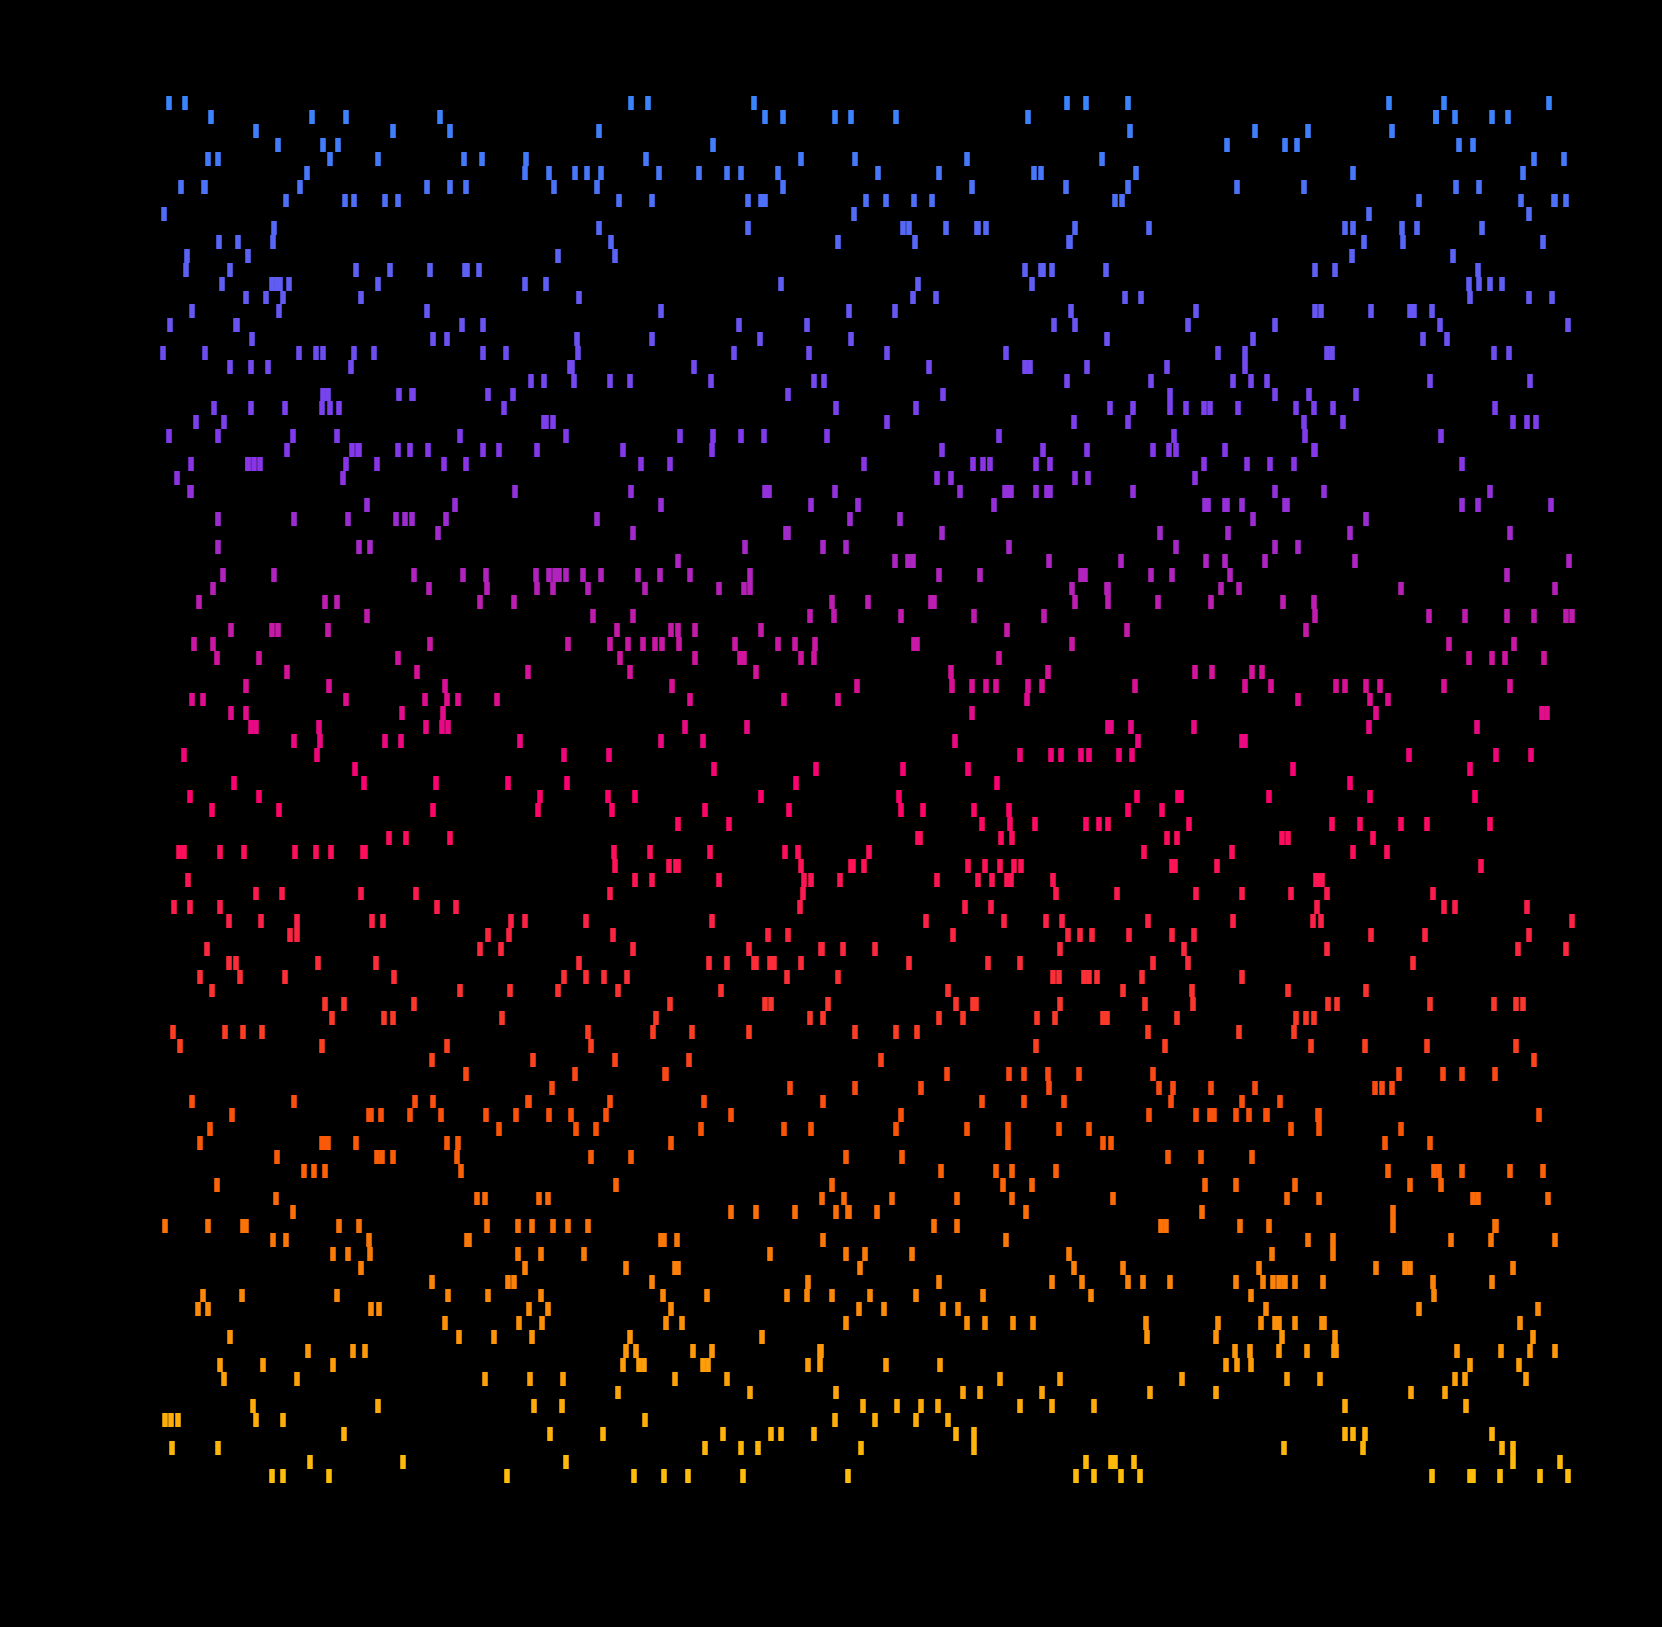

In [3]:
# Create network
graph = nx.watts_strogatz_graph(
    n_neurons,
    p=0.1,
    k=7,
    seed=42
)

# Set node names
node_names = {i: f'PC_{i}' for i in range(n_neurons)}
graph = nx.relabel_nodes(graph, node_names)

# Create voltage traces
time, voltages, _ = create_population_voltage_matrix(
    spike_times_dict, t_start=0, t_end=t_max, dt=dt, sigma=0.5)


# Create animations
pos = nx.spring_layout(graph, seed=42)

# Create colored nodes using viridis colormap
node_colors = get_colormap()(np.linspace(0, 1, n_neurons))
node_colors_shuffled = node_colors.copy()
np.random.shuffle(node_colors_shuffled)

# Simulate voltage traces
time, voltages, _ = create_population_voltage_matrix(spike_times_dict, t_start=0, t_end=t_max, dt=dt, sigma=0.5)

save_folder = '/Users/artemkirsanov/YouTube/SWR memory selection/Code/animations/population_activity'
animate_network(graph, pos, voltages, save_folder, node_colors_shuffled)
animate_spike_trains(t, spike_times_dict, save_folder, node_colors)